In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing

import pyLDAvis
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

#from imblearn.over_sampling import SMOTE 
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pickle
import joblib
import spacy

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
#from textblob import TextBlob
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings
#import gensim
#from gensim.utils import simple_preprocess
#from gensim.parsing.preprocessing import STOPWORDS
#from bs4 import BeautifulSoup
#from gensim import corpora, models
#from gensim.models import Phrases
#from gensim.models import CoherenceModel
#from gensim.corpora.dictionary import Dictionary

In [5]:
raw_df= pd.read_csv(r'G:/Symbi/Dataset/TelecomPOC New.csv',encoding='utf-8', parse_dates=[1])
raw_df.head()
neg = raw_df[raw_df.Sentiment1=='Negative']

neg = neg.reset_index(drop=True)
text = neg.Tweet.dropna()
print(text)

#raw_df= raw_df[pd.notnull(raw_df['Tweet'])] #Delete rows where Tweet is null.

0       @Vodafone won't not let me port to @JioCare f...
1            @jiocare Jio internet services depressing. 
2      @jiocare #jiofraud, no action in my complaint,...
3      @jiocare Was recharging for Jio 999 plan. When...
4      @jiocare It's been officially 10 days. Yet, no...
                             ...                        
318    Customer wants to block calls from a particula...
319                                Checking IMEI status.
320    Called to report demise of her grandmother & w...
321                                Checking IMEI status.
322                                               #call?
Name: Tweet, Length: 323, dtype: object


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
def clean_tweet(RawSentence):
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
        
    txt = RawSentence.lower()
    word_tokens = word_tokenize(txt)    
    #word_tokens = word_tokenize(RawSentence)    
    
    lemma = WordNetLemmatizer()
    nlp = spacy.load('en_core_web_sm') 

    stop_words = set(stopwords.words('english'))
    stop_words.update(["amp", "rt", "cc"]) # adding twitter specific stop words
    #stop_words = stop_words - set(['no', 'not','nil'])  #removing No, not, nil from stop words     
    stop_words.update(["worst","airtelpresence","sunday","monday","tuesday","wednesday","thursday","friday","saturday",
                       "weekend","apparently","extremely","worse","consolation","shouldnt","wont","arent","maybe"
                     "better", "other","instead","look","yesterday","unacceptable","miss","couldnt","depress","let",
                     "thank","actually","frustrate","ridiculous","expect","pathetic","terrible","hathway",
                     "impossible","ask","earlier","literally","years","surprise","horrible","airtel","current","face",
                     "upset","pls","one","two","three","four","empty","please","good","finally","proper","development",
                     "situation","company","believe","question","anymore","consolation","mess","shock","longer","twitter",
                      "completely","finally", "waste","shock","annoy","strand",
                      "important","break","reason", "first","second","third","attempt","officially","absolutely","hello","yet","know","jio",
                      "january","february","march","april","may","june","july","august","september","october","november","december","without",
                      "vodafone","get","vodafoneidea","vicustomercare","vowifi","since","voda","reliancejio","jiocare","time","number"])
   
    txt = re.sub(r"(@\S+)", "", txt)  # remove @
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters from within the text (it's -> it s then we need to remove s)
    txt = re.sub(r'\^[a-zA-Z]\s+', ' ', txt) # remove all single characters from beginning of the text 
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    #txt = re.sub(r'^b\s+', '', txt) # generally used when text is scrapped online. 'b' is prefixed often indicating binary text. This is not reqd for us 
    txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    txt = ' '.join([i for i in txt.split(" ") if i not in stop_words])   # split() is native tokenizer in Python
    #txt = ' '.join(lemma.lemmatize(word) for word in txt.split())           # Used lemmatizer later 
    #txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    #soup = BeautifulSoup(txt) #to scrap information from web pages....not needed here
    #txt = soup.get_text
    
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemma.lemmatize(item,'v'))
        return lemmatized
    
    txt = deEmojify(txt)
    tokens =[]
    
    excluded_tags = {"ADJ", "ADV", "ADP", "PROPN","CCONJ","AUX","DET","PRON"}
    for token in nlp(txt):
        if token.pos_ not in excluded_tags:
            tokens.append(token.text)
    
    lemm = stem_tokens(tokens, lemma)
    #tokens = nltk.word_tokenize(txt)
    tokens = [ch for ch in lemm if len(ch)>2] #remove words with character length below 3
    #tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    
    joined_text = ' '.join(tokens)
        
    return joined_text

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:36: DeprecationWarning: invalid escape sequence \s
<>:36: DeprecationWarning: invalid escape sequence \s
<ipython-input-75-903925a105e3>:36: DeprecationWarning: invalid escape sequence \s
  txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters


In [76]:
raw_df['clean_tweet'] = raw_df.Tweet.apply(clean_tweet)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
# vectorize the corpus. the vectorizer object will convert text to vector form on the basis of frequency (count) of each word in text
#Vectorization is a process of converting the text data into a machine-readable form. Each word forms the index. 
#min_df - will ignore words that are present in min_df percent or less no of documents 
#max_df - will take words that are present in max df percent of all the documents

#vectorizer = CountVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=20, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
vectorizer = CountVectorizer(max_df=.95, min_df=0.05, ngram_range=(1,2),token_pattern='\w+|\$[\d\.]+|\S+')
#vectorizer = CountVectorizer(max_df=0.9, min_df=0.2, ngram_range=(1,2)) 
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2))


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:8: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \w
<ipython-input-141-135cc23e7235>:8: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=.95, min_df=0.05, ngram_range=(1,2),token_pattern='\w+|\$[\d\.]+|\S+')


In [142]:
# apply transformation. fit_transform() first fits to data, then transform it or vectorizes it.  
from sklearn.feature_extraction.text import TfidfTransformer 

tf = vectorizer.fit_transform(raw_df['clean_tweet']).toarray()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(raw_df['clean_tweet']).toarray()

print("FEATURE MATRIX IS ",tf)
tf_shape = tf.shape
print("Feature Matrix shape is :",tf_shape)

tfidf_shape = tfidf_feature_matrix.shape
print("TF-IDF Feature Matrix shape is :",tfidf_shape)
print("TF-IDF Feature matrix not getting printed \n")

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
print("Feature names are : ",tf_feature_names)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#print("TF-IDF Feature names are : ",tfidf_feature_names)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(tf)
#this transformation is not needed for NMF 

# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

#model1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0,doc_topic_prior=0.1, topic_word_prior=0.01)
#print(model1)
#model1.fit(tf)
#Learn model for the data X with variational Bayes method.
# print log-likelihood

#log_likelihood1 =model1.score(tf)
#perplexity1= model1.perplexity(tf)
#print("  ")
#print("Log likelihood: ", log_likelihood1)
#print("Perplexity: ", perplexity1)



FEATURE MATRIX IS  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
Feature Matrix shape is : (362, 21)
TF-IDF Feature Matrix shape is : (362, 60)
TF-IDF Feature matrix not getting printed 

Feature names are :  ['area', 'bill', 'call', 'check', 'complaint', 'connection', 'customer', 'data', 'days', 'get', 'give', 'internet', 'issue', 'month', 'network', 'plan', 'port', 'service', 'speed', 'want', 'work']


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,idf_weights
service,2.487684
network,2.689710
call,2.783529
customer,2.783529
want,2.982380
speed,3.065761
internet,3.087740
plan,3.180831
connection,3.205523
port,3.339055


In [79]:
#####################################
## Utility functions to help with NMF
# Code adapted from Sarkar text book
#####################################

# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=5,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=5,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6,7,8,9,10,12,14,16,18,20], 'learning_decay': [.5, .7, .9]}  
#n_components - no of features to be used, learning_decay - between 0.5 & 1. Corresponds to kappa - what value of previous lambda is forgotton

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model2 = GridSearchCV(lda, search_params)   #loops through predefined hyperparams to fit model on training set.

model2.fit(tf)
best_lda_model = model2.best_estimator_
print("Best model's params: ", model2.best_params_)
print("Best log likelihood score: ", model2.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tf))

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best model's params:  {'learning_decay': 0.5, 'n_components': 2}
Best log likelihood score:  -599.1149633123309
Model perplexity:  20.486087589800807


In [111]:
df_cv_results = pd.DataFrame(model2.cv_results_)
df_cv_results.to_csv("G:\Symbi\Outcome\LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<ipython-input-111-80119f720312>:2: DeprecationWarning: invalid escape sequence \S
  df_cv_results.to_csv("G:\Symbi\Outcome\LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

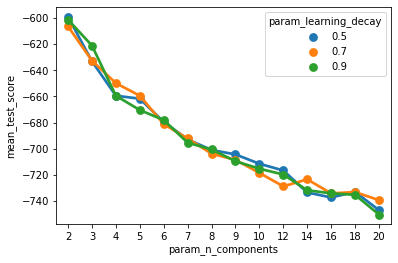

In [112]:
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

In [83]:
# Take the best model
best_lda_model

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_decay=0.9, n_components=2)

In [143]:
model3=LatentDirichletAllocation(batch_size=10, doc_topic_prior=0.1,learning_method='batch', evaluate_every=1, 
            learning_offset=10.0,learning_decay=0.5,n_components=5,
            max_doc_update_iter=50, max_iter=50, mean_change_tol=0.001,n_jobs=None, perp_tol=0.1,random_state=None, topic_word_prior=0.01,
            total_samples=500.0, verbose=0)

model3.fit(tf)
#Learn model for the data X with variational Bayes method.
# print log-likelihood

log_likelihood3 =model3.score(tf)
perplexity3= model3.perplexity(tf)
print("  ")
print("Log likelihood: ", log_likelihood3)
print("Perplexity: ", perplexity3)

# Learning_method = {"batch","online"} - Batch Variational Bayes method is used in small dataset. For big dataset, online method is good
# batch_size - Variational Bayes size 
# n_components = no of topics
# doc_topic_prior =float, default=None. Default value = 1 / n_components. Alpha. Prior of document topic distribution theta. 
# topic_word_prior = float. Beta. Prior of topic-word distribtion. 

lda_output = model3.transform(tf)
#print(lda_output)

#lda_output.save('G:/Symbi/Outcome/model3.model')

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  
Log likelihood:  -2844.5935907492753
Perplexity:  26.203523970661404


In [120]:
lda_weights = model3.components_
topics = get_topics_terms_weights(lda_weights, tf_feature_names)
#topics_display_list = get_topics_udf(topics, total_topics=4, num_terms=30)
print_topics_udf(topics, total_topics=5, num_terms=30, display_weights=True)

Topic #1 with weights
[('connection', 50.01), ('call', 42.01), ('check', 11.53), ('want', 9.23), ('days', 7.11), ('port', 6.01), ('area', 2.99), ('complaint', 0.01), ('bill', 0.01), ('customer', 0.01), ('data', 0.01), ('work', 0.01), ('get', 0.01), ('internet', 0.01), ('issue', 0.01), ('month', 0.01), ('network', 0.01), ('plan', 0.01), ('service', 0.01), ('speed', 0.01), ('give', 0.01)]
Topic #2 with weights
[('speed', 55.01), ('internet', 39.95), ('data', 22.73), ('network', 7.79), ('give', 7.18), ('area', 4.97), ('check', 4.75), ('complaint', 2.17), ('plan', 0.01), ('month', 0.01), ('issue', 0.01), ('port', 0.01), ('want', 0.01), ('get', 0.01), ('days', 0.01), ('service', 0.01), ('customer', 0.01), ('connection', 0.01), ('call', 0.01), ('bill', 0.01), ('work', 0.01)]
Topic #3 with weights
[('service', 91.01), ('bill', 28.01), ('port', 26.34), ('customer', 18.24), ('want', 10.53), ('month', 8.2), ('work', 5.76), ('give', 4.41), ('complaint', 2.8), ('issue', 0.01), ('internet', 0.01), 

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
tweet_txt = raw_df['clean_tweet']

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [122]:
# column names
topicnames = ['Topic_' + str(i) for i in range(model3.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(tweet_txt))]

# create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)

df_document_topic.head(10)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
Doc_0,0.07,0.07,0.73,0.07,0.07
Doc_1,0.04,0.44,0.44,0.04,0.04
Doc_2,0.07,0.07,0.07,0.07,0.73
Doc_3,0.03,0.03,0.03,0.89,0.03
Doc_4,0.07,0.07,0.07,0.07,0.73
Doc_5,0.20,0.20,0.20,0.20,0.20
Doc_6,0.07,0.07,0.07,0.07,0.73
Doc_7,0.02,0.40,0.02,0.30,0.26
Doc_8,0.04,0.04,0.04,0.04,0.84
Doc_9,0.04,0.04,0.04,0.44,0.44


In [123]:
df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic.head(10)
df_document_topic
df_document_topic.to_csv('G:/Symbi/Outcome/dominant_topic.csv', index=True)
df_document_topic.to_excel('G:/Symbi/Outcome/dominant_topic.xls', index=True)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Tanisha Batra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dominant_topic', ylabel='count'>

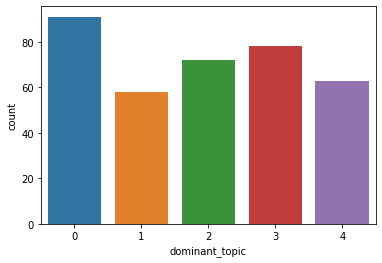

In [124]:
sns.countplot(df_document_topic.dominant_topic)


In [125]:
# components_ contains the word to topic matrix
model3.components_.shape
# check the shape
tf.shape

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(362, 21)

In [127]:
# Topic - Keyword matrix. Each topic keywords

df_topic_keywords = pd.DataFrame(model3.components_)

# assign column and index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# check the head
df_topic_keywords.iloc[:,:20]

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,area,bill,call,check,complaint,connection,customer,data,days,get,give,internet,issue,month,network,plan,port,service,speed,want
Topic_0,2.990308,0.01,42.010542,11.528542,0.010000,50.01,0.010000,0.010000,7.114254,0.01,0.010000,0.010000,0.01,0.010000,0.010000,0.01,6.009940,0.01,0.01,9.233539
Topic_1,4.967806,0.01,0.010000,4.752138,2.168263,0.01,0.010000,22.734904,0.010000,0.01,7.177056,39.947189,0.01,0.010000,7.794489,0.01,0.010000,0.01,55.01,0.010000
Topic_2,0.010000,28.01,0.010000,0.010000,2.797601,0.01,18.242686,0.010000,0.010000,0.01,4.405707,0.010000,0.01,8.201226,0.010000,0.01,26.343495,91.01,0.01,10.534087
Topic_3,0.010000,0.01,24.009458,5.749320,0.010000,0.01,45.777314,13.285096,0.010000,24.01,2.795747,0.010000,0.01,10.330139,0.010000,46.01,0.010000,0.01,0.01,30.262374
Topic_4,13.071886,0.01,0.010000,0.010000,17.064136,0.01,0.010000,0.010000,18.905746,0.01,4.661491,10.072811,35.01,1.498635,78.225511,0.01,2.676565,0.01,0.01,0.010000


In [128]:
# Show top n keywords for each topic
#vectorizer=vectorizer, 
#lda_model=model3, 
n_words=20
keywords = np.array(vectorizer.get_feature_names())

topic_keywords = []
for topic_weights in model3.components_:
    top_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(top_keyword_locs))
    
topic_keywords

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[array(['connection', 'call', 'check', 'want', 'days', 'port', 'area',
        'complaint', 'speed', 'service', 'plan', 'network', 'month',
        'give', 'internet', 'get', 'data', 'customer', 'bill', 'issue'],
       dtype='<U10'),
 array(['speed', 'internet', 'data', 'network', 'give', 'area', 'check',
        'complaint', 'customer', 'days', 'get', 'want', 'issue', 'month',
        'call', 'plan', 'port', 'service', 'bill', 'connection'],
       dtype='<U10'),
 array(['service', 'bill', 'port', 'customer', 'want', 'month', 'work',
        'give', 'complaint', 'days', 'get', 'connection', 'internet',
        'issue', 'network', 'plan', 'check', 'call', 'speed', 'data'],
       dtype='<U10'),
 array(['plan', 'customer', 'want', 'get', 'call', 'data', 'month',
        'check', 'give', 'speed', 'service', 'port', 'network', 'area',
        'internet', 'days', 'connection', 'complaint', 'bill', 'issue'],
       dtype='<U10'),
 array(['network', 'issue', 'work', 'days', 'complaint', 'ar

In [129]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,connection,call,check,want,days,port,area,complaint,speed,service,plan,network,month,give,internet,get,data,customer,bill,issue
Topic 1,speed,internet,data,network,give,area,check,complaint,customer,days,get,want,issue,month,call,plan,port,service,bill,connection
Topic 2,service,bill,port,customer,want,month,work,give,complaint,days,get,connection,internet,issue,network,plan,check,call,speed,data
Topic 3,plan,customer,want,get,call,data,month,check,give,speed,service,port,network,area,internet,days,connection,complaint,bill,issue
Topic 4,network,issue,work,days,complaint,area,internet,give,port,month,customer,data,check,get,want,call,bill,plan,service,speed


In [145]:
# normalize the corpus
#t1 ='@jiocare, I paid on time, why is there fine. Cancel the fine and send a new bill '
#t2 ='@airtel I have complained so many times, but network quality is not improved. Rampant call drop'

test_df= pd.read_csv(r'G:/Symbi/Dataset/TestTweets.csv',encoding='utf-8', parse_dates=[1])
test_df= test_df[pd.notnull(test_df['Test_Tweet'])] #Delete rows where Tweet is null.

test_df['clean_tweet'] = test_df.Test_Tweet.apply(clean_tweet)

#clean_test = clean_tweet(test_corpus)
#clean_test = [' '.join(text) for text in clean_test]
#clean_test =[clean_test]
#print(clean_test)
#test_feature_matrix = vectorizer.fit_transform(clean_test)

testf = vectorizer.fit_transform(test_df['clean_tweet']).toarray()
print("Test Feature Matrix  ",testf)
testf_shape = testf.shape
print("Test Feature Matrix shape is :",testf_shape)

test_feature_names = vectorizer.get_feature_names()
print("Feature names are : ",test_feature_names)

testfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
testfidf_transformer.fit(testf)
#this transformation is not needed for NMF 

# print idf values 
test_idf = pd.DataFrame(testfidf_transformer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
test_idf.sort_values(by=['idf_weights'])

test_lda_output = model3.transform(testf)
# column names
test_topicnames = ['Topic_' + str(i) for i in range(model3.n_components)]

# index names
test_docnames = ['Doc_' + str(i) for i in range(len(clean_test))]

# create a dataframe
test_df_document_topic = pd.DataFrame(np.round(test_lda_output,2), columns=test_topicnames, index=test_docnames)

# dominant topic
test_df_document_topic['dominant_topic'] = np.argmax(test_df_document_topic.values, axis=1)
test_df_document_topic.head()

#print(clean_test_corpus)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [137]:
import pyLDAvis.sklearn

dtm = np.matrix(tf)
print(vectorizer.get_feature_names())
print(tf)
panel = pyLDAvis.sklearn.prepare(model3, dtm, vectorizer,mds='tsne')
pyLDAvis.display(panel)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['area', 'bill', 'call', 'check', 'complaint', 'connection', 'customer', 'data', 'days', 'get', 'give', 'internet', 'issue', 'month', 'network', 'plan', 'port', 'service', 'speed', 'want', 'work']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
